In [14]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
import os

In [15]:
carpeta_no2 = "Datasets\Datos_SIATA_Aire_no2.json"

with open(carpeta_no2, "r", encoding="utf-8") as f:data = json.load(f)

registros = []

        
for estacion in data:
    lat = estacion.get("latitud")
    lon = estacion.get("longitud")
    codigo = estacion.get("codigoSerial")
    nombre = estacion.get("nombre")
    nombreCorto = estacion.get("nombreCorto")
    datos = estacion.get("datos", [])

    for entrada in datos:
        registros.append({
            "codigoSerial": codigo,
            "nombreCorto": nombreCorto,
            "nombre": nombre,
            "latitud": lat,
            "longitud": lon,
            "contaminante": entrada.get("variableConsulta"),
            "fecha": entrada.get("fecha"),
            "calibracion": entrada.get("valor"), # Ojooo esto es calibración 
            "valor": entrada.get("calidad") # Y esto calidad, osea que la calidad se llama valor y la calibración valga la redundancia calibración 
        })

# Convertimos a DataFrame como antes
df = pd.DataFrame(registros)
df['fecha'] = pd.to_datetime(df['fecha'], errors='coerce')
df['valor'] = pd.to_numeric(df['valor'], errors='coerce')
df["calibracion"] = pd.to_numeric(df["calibracion"], errors='coerce')


df.loc[df["calibracion"] == -9999, 'valor'] = np.nan

print(df.head(20))

    codigoSerial nombreCorto                               nombre   latitud  \
0              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
1              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
2              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
3              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
4              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
5              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
6              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
7              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
8              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
9              3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
10             3    GIR-SOSN  _OFF-Girardota - S.O.S Aburrá Norte  6.378433   
11             3    GIR-SOSN  _OFF-Girardota - S.O.S

In [16]:
validos_por_estacion = df.groupby('nombreCorto')['valor'].apply(lambda x: x.notna().mean() * 100)
validos_por_contaminante = df.groupby('contaminante')['valor'].apply(lambda x: x.notna().mean() * 100)
print(f"Porcentaje datos válidos por estación\n{validos_por_estacion}\n\nPorcentaje datos válidos por contaminante{validos_por_contaminante}")

Porcentaje datos válidos por estación
nombreCorto
BEL-USBV     0.000000
GIR-SOSN     0.045657
ITA-CJUS    99.326561
MED-ITMR    95.879466
MED-PJIC    95.251684
MED-UNNV     0.000000
SUR-TRAF    94.418445
Name: valor, dtype: float64

Porcentaje datos válidos por contaminantecontaminante
no2    54.98883
Name: valor, dtype: float64


In [17]:
# Obtener contaminante único (ya que el archivo es solo de uno)
contaminante_unico = df['contaminante'].unique()[0] if not df['contaminante'].isna().all() else "Desconocido"


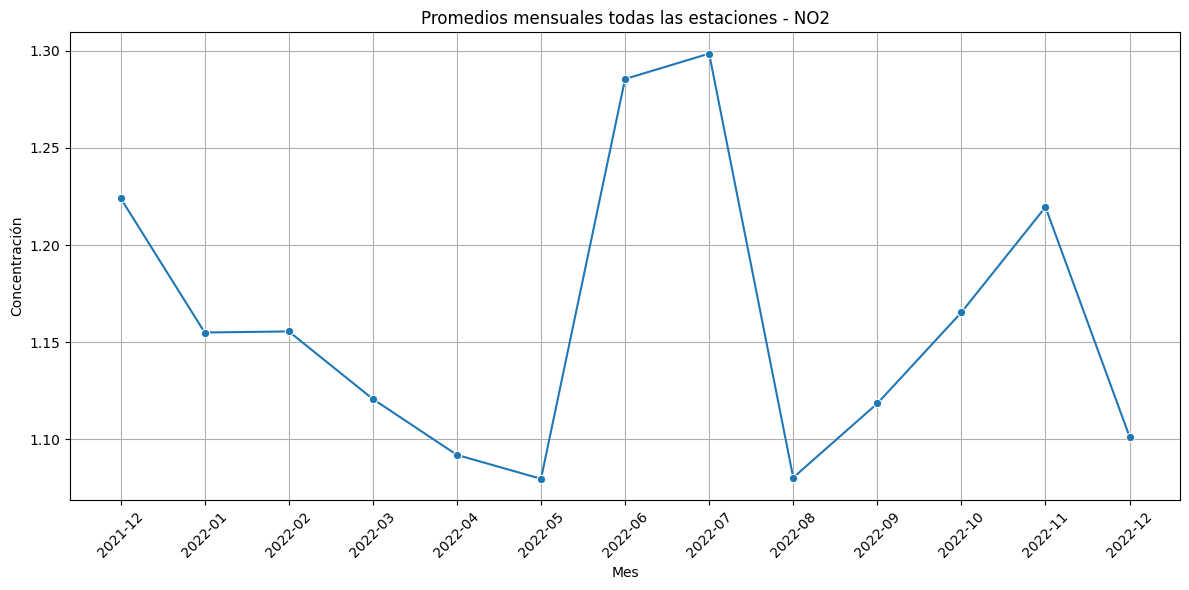

In [18]:
df['mes'] = df['fecha'].dt.to_period("M")
promedios_mensuales = df.groupby('mes')['valor'].mean().reset_index()
promedios_mensuales['mes'] = promedios_mensuales['mes'].astype(str)

# Graficar
plt.figure(figsize=(12,6))
sns.lineplot(data=promedios_mensuales, x='mes', y='valor', marker='o')
plt.title(f'Promedios mensuales todas las estaciones - {contaminante_unico.upper()}')
plt.xlabel('Mes')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# 5. Mapa estático de estaciones segun datos validos



# Media por estacion
media_estaciones = df.groupby(['codigoSerial', 'nombre', 'latitud', 'longitud'])['valor'].mean().reset_index()

validos_por_estacion = df.groupby('codigoSerial')['valor'].apply(lambda x: x.notna().mean() * 100)

media_estaciones['porcentaje_validos'] = media_estaciones['codigoSerial'].map(validos_por_estacion)


mapa = folium.Map(location=[6.25, -75.6], zoom_start=11)

for _, row in media_estaciones.iterrows():
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=6,
        popup=(
            f"Estación {row['nombre']}\n"
            f"Media: {row['valor']:.2f}\n"
            f"Válidos: {row['porcentaje_validos']:.1f}%"
        ),
        color = 'green' if row['porcentaje_validos'] >= 51 else 'red',
        fill=True,
    ).add_to(mapa)

mapa

In [20]:
# mapa por estacion según concentracion de la partícula


# Media por estación
media_estaciones = df.groupby(['codigoSerial', 'nombre', 'latitud', 'longitud'])['valor'].mean().reset_index()

# Porcentaje de datos válidos por estación
validos_por_estacion = df.groupby('codigoSerial')['valor'].apply(lambda x: x.notna().mean() * 100)
media_estaciones['porcentaje_validos'] = media_estaciones['codigoSerial'].map(validos_por_estacion)

# Clasificación de color según niveles de concentración promedio
def clasificar_calidad_aire(valor, contaminante):
    if pd.isna(valor):
        return "Sin datos"
    
    contaminante = contaminante.lower()
    
    if contaminante == 'pm25':
        if valor <= 12:
            return "Bueno"
        elif valor <= 35.4:
            return "Aceptable"
        elif valor <= 55.4:
            return "No saludable sensibles"
        elif valor <= 150.4:
            return "No saludable"
        elif valor <= 250.4:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'pm10':
        if valor <= 54:
            return "Bueno"
        elif valor <= 154:
            return "Aceptable"
        elif valor <= 254:
            return "No saludable sensibles"
        elif valor <= 354:
            return "No saludable"
        elif valor <= 424:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'co':
        if valor <= 4.4:
            return "Bueno"
        elif valor <= 9.4:
            return "Aceptable"
        elif valor <= 12.4:
            return "No saludable sensibles"
        elif valor <= 15.4:
            return "No saludable"
        elif valor <= 30.4:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'o3':
        if valor <= 0.054:
            return "Bueno"
        elif valor <= 0.070:
            return "Aceptable"
        elif valor <= 0.085:
            return "No saludable sensibles"
        elif valor <= 0.105:
            return "No saludable"
        elif valor <= 0.200:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'no2':
        if valor <= 0.053:
            return "Bueno"
        elif valor <= 0.100:
            return "Aceptable"
        elif valor <= 0.360:
            return "No saludable sensibles"
        elif valor <= 0.649:
            return "No saludable"
        elif valor <= 1.249:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'so2':
        if valor <= 0.035:
            return "Bueno"
        elif valor <= 0.075:
            return "Aceptable"
        elif valor <= 0.185:
            return "No saludable sensibles"
        elif valor <= 0.304:
            return "No saludable"
        elif valor <= 0.604:
            return "Muy no saludable"
        else:
            return "Peligroso"

    elif contaminante == 'no' or contaminante == 'pm1':
        return "Sin estándar oficial"

    else:
        return "Contaminante desconocido"
    
def color_por_categoria(categoria):
    colores = {
        "Bueno": "green",
        "Aceptable": "yellow",
        "No saludable sensibles": "orange",
        "No saludable": "red",
        "Muy no saludable": "purple",
        "Peligroso": "maroon",
        "Sin datos": "gray",
        "Sin estándar oficial": "blue",
        "Contaminante desconocido": "black"
    }
    return colores.get(categoria, "black")


# Crear mapa
mapa = folium.Map(location=[6.25, -75.6], zoom_start=11)

for _, row in media_estaciones.iterrows():
    categoria = clasificar_calidad_aire(row['valor'], contaminante_unico) 
    color = color_por_categoria(categoria)
    radio = 4 + (row['valor'] / 5) if not pd.isna(row['valor']) else 4
    folium.CircleMarker(
        location=[row['latitud'], row['longitud']],
        radius=radio,
        popup=folium.Popup(
            f"<b>{row['nombre']}</b><br>"
            f"Media: {row['valor']:.2f}<br>"
            f"Categoría: {categoria}<br>"
            f"Válidos: {row['porcentaje_validos']:.1f}%",
            max_width=300
        ),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7
    ).add_to(mapa)

# Mostrar mapa en notebook
mapa

In [21]:
df['categoria_calidad'] = df.apply(
    lambda row: clasificar_calidad_aire(row['valor'], row['contaminante']),
    axis=1
)
df


,codigoSerial,nombreCorto,nombre,latitud,longitud,contaminante,fecha,calibracion,valor,mes,categoria_calidad
0,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,no2,2021-12-14 04:00:00,-9999.000000,NaN,2021-12,Sin datos
1,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,no2,2021-12-14 05:00:00,-9999.000000,NaN,2021-12,Sin datos
2,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,no2,2021-12-14 06:00:00,-9999.000000,NaN,2021-12,Sin datos
3,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,no2,2021-12-14 07:00:00,-9999.000000,NaN,2021-12,Sin datos
4,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,no2,2021-12-14 08:00:00,-9999.000000,NaN,2021-12,Sin datos
...,...,...,...,...,...,...,...,...,...,...,...
61322,74,MED-ITMR,Institucion Universitaria ITM Robledo,6.275564,-75.588287,no2,2022-12-14 00:00:00,26.392570,1.0,2022-12,Muy no saludable
61323,74,MED-ITMR,Institucion Universitaria ITM Robledo,6.275564,-75.588287,no2,2022-12-14 01:00:00,23.374680,1.0,2022-12,Muy no saludable
61324,74,MED-ITMR,Institucion Universitaria ITM Robledo,6.275564,-75.588287,no2,2022-12-14 02:00:00,16.647036,1.0,2022-12,Muy no saludable
61325,74,MED-ITMR,Institucion Universitaria ITM Robledo,6.275564,-75.588287,no2,2022-12-14 03:00:00,16.178519,1.0,2022-12,Muy no saludable


datos importantes

In [22]:
df['dia_semana'] = df['fecha'].dt.weekday  # Lunes=0, Domingo=6
df['es_fin_semana'] = df['dia_semana'] >= 5

In [23]:

eventos_especiales = {
    '2021-12-24': 'Navidad',
    '2021-12-31': 'Año Nuevo',
    '2022-01-06': 'Día de Reyes',
    '2022-04-10': 'Semana Santa',
    '2022-04-15': 'Semana Santa',
    '2022-07-20': 'Independencia',
    '2022-08-07': 'Feria de las Flores',
    '2022-08-08': 'Feria de las Flores',
    '2022-09-22': 'Día sin carro',
    '2022-10-31': 'Halloween',
    '2022-12-07': 'Día de las Velitas',
    '2022-12-24': 'Navidad',
    '2022-12-31': 'Año Nuevo',
    # Puedes seguir agregando...
}

In [24]:
df['fecha_str'] = df['fecha'].dt.strftime('%Y-%m-%d')
df['evento'] = df['fecha_str'].map(eventos_especiales).fillna("Normal")
df

,codigoSerial,nombreCorto,nombre,latitud,longitud,contaminante,fecha,calibracion,valor,mes,categoria_calidad,dia_semana,es_fin_semana,fecha_str,evento
0,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,no2,2021-12-14 04:00:00,-9999.000000,NaN,2021-12,Sin datos,1,False,2021-12-14,Normal
1,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,no2,2021-12-14 05:00:00,-9999.000000,NaN,2021-12,Sin datos,1,False,2021-12-14,Normal
2,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,no2,2021-12-14 06:00:00,-9999.000000,NaN,2021-12,Sin datos,1,False,2021-12-14,Normal
3,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,no2,2021-12-14 07:00:00,-9999.000000,NaN,2021-12,Sin datos,1,False,2021-12-14,Normal
4,3,GIR-SOSN,_OFF-Girardota - S.O.S Aburrá Norte,6.378433,-75.451141,no2,2021-12-14 08:00:00,-9999.000000,NaN,2021-12,Sin datos,1,False,2021-12-14,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61322,74,MED-ITMR,Institucion Universitaria ITM Robledo,6.275564,-75.588287,no2,2022-12-14 00:00:00,26.392570,1.0,2022-12,Muy no saludable,2,False,2022-12-14,Normal
61323,74,MED-ITMR,Institucion Universitaria ITM Robledo,6.275564,-75.588287,no2,2022-12-14 01:00:00,23.374680,1.0,2022-12,Muy no saludable,2,False,2022-12-14,Normal
61324,74,MED-ITMR,Institucion Universitaria ITM Robledo,6.275564,-75.588287,no2,2022-12-14 02:00:00,16.647036,1.0,2022-12,Muy no saludable,2,False,2022-12-14,Normal
61325,74,MED-ITMR,Institucion Universitaria ITM Robledo,6.275564,-75.588287,no2,2022-12-14 03:00:00,16.178519,1.0,2022-12,Muy no saludable,2,False,2022-12-14,Normal


In [25]:
#Semana vs fin de semana

promedios_dia = df.groupby('es_fin_semana')['valor'].mean()
print(promedios_dia)

es_fin_semana
False    1.168027
True     1.143077
Name: valor, dtype: float64


In [26]:
#fechas especiales vs fechas normales

promedios_evento = df.groupby('evento')['valor'].mean()
print(promedios_evento)

evento
Año Nuevo              1.225000
Día de Reyes           1.340625
Día de las Velitas     1.168056
Día sin carro          1.146809
Feria de las Flores    1.264921
Halloween              1.286458
Independencia          1.225000
Navidad                1.237500
Normal                 1.159681
Semana Santa           1.014062
Name: valor, dtype: float64


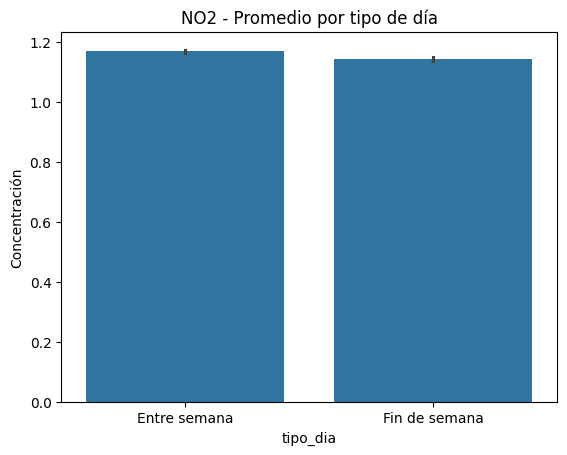

In [27]:
df['dia_semana'] = df['fecha'].dt.weekday
df['tipo_dia'] = df['dia_semana'].apply(lambda x: 'Fin de semana' if x >= 5 else 'Entre semana')

sns.barplot(data=df, x='tipo_dia', y='valor')
plt.title(f'{contaminante_unico.upper()} - Promedio por tipo de día')
plt.ylabel('Concentración')
plt.show()

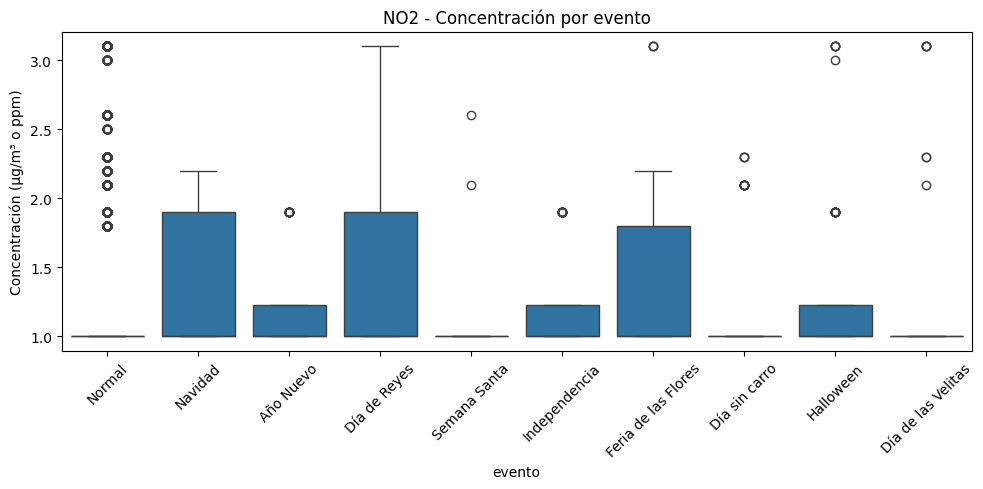

In [28]:
#Semana vs fin de semana
plt.figure(figsize=(10, 5))
sns.boxplot(data=df, x='evento', y='valor')
plt.title(f'{contaminante_unico.upper()} - Concentración por evento')
plt.ylabel('Concentración (μg/m³ o ppm)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [29]:
#fechas especiales vs fechas normales
resumen = df.groupby(['tipo_dia', 'evento'])['valor'].mean().unstack()
resumen

evento,Año Nuevo,Día de Reyes,Día de las Velitas,Día sin carro,Feria de las Flores,Halloween,Independencia,Navidad,Normal,Semana Santa
tipo_dia,,,,,,,,,,
Entre semana,1.225,1.340625,1.168056,1.146809,1.306316,1.286458,1.225,1.2375,1.166166,1.028125
Fin de semana,NaN,NaN,NaN,NaN,1.223958,NaN,NaN,NaN,1.143709,1.000000


                                              nombre     valor
3                   Itagüí - Casa de Justicia Itagüí  1.264192
1  Politecnico Colombiano Jaime Isaza Cadavid - M...  1.163463
6              Institucion Universitaria ITM Robledo  1.149143
5                          _OFF-Estación Tráfico Sur  1.061666
0                _OFF-Girardota - S.O.S Aburrá Norte  1.000000
2  _OFF-Medellín,  centro occidente - Universidad...       NaN
4                       Universidad San Buenaventura       NaN


C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_21316\1972914900.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




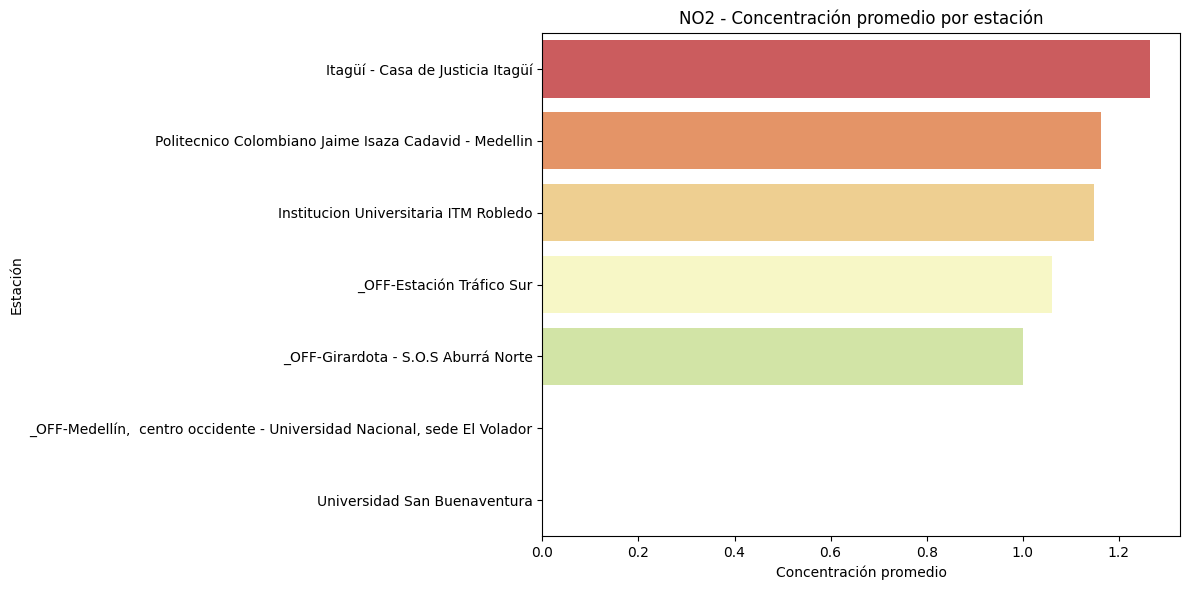

In [30]:
#estaciones con peor aire

media_top = media_estaciones[['nombre', 'valor']].sort_values(by='valor', ascending=False)
print(media_top.head(10))
plt.figure(figsize=(12, 6))
estaciones_ordenadas = media_estaciones.sort_values(by='valor', ascending=False)
sns.barplot(data=estaciones_ordenadas, x='valor', y='nombre', palette='Spectral')
plt.title(f'{contaminante_unico.upper()} - Concentración promedio por estación')
plt.xlabel('Concentración promedio')
plt.ylabel('Estación')
plt.tight_layout()
plt.show()

In [31]:
media_plot = media_estaciones.dropna(subset=['valor'])


import plotly.express as px

fig = px.scatter_mapbox(
    media_plot,
    lat="latitud", lon="longitud",
    color="valor",
    size="valor",
    hover_name="nombre",
    color_continuous_scale="YlOrRd",
    size_max=15,
    zoom=10,
    mapbox_style="carto-positron"
)
fig.update_layout(title=f'{contaminante_unico.upper()} - Concentración por estación')
fig.show()

C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_21316\3915280519.py:6: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/



In [32]:
limites_normativos = {
    'pm25': 25,   # μg/m³ (24h) - OMS
    'pm10': 50,   # μg/m³ (24h) - OMS
    'ozono': 0.051,  # ppm (8h) - OMS 100 μg/m³ → 0.051 ppm aprox
    'co': 4.0,    # ppm (24h) - OMS
    'no2': 0.025, # ppm (1h) - OMS
    'so2': 0.005, # ppm (24h) - OMS
    # otros...
}

In [33]:
contaminante = contaminante_unico.lower()
limite = limites_normativos.get(contaminante, None)

if limite:
    df['excede_limite'] = df['valor'] > limite
    excedencias = df['excede_limite'].mean() * 100
    print(f"📌 Porcentaje de registros que exceden el límite OMS para {contaminante.upper()}: {excedencias:.2f}%")
else:
    print("No hay límite definido para este contaminante.")
#gafico de dias que exceden

📌 Porcentaje de registros que exceden el límite OMS para NO2: 54.99%


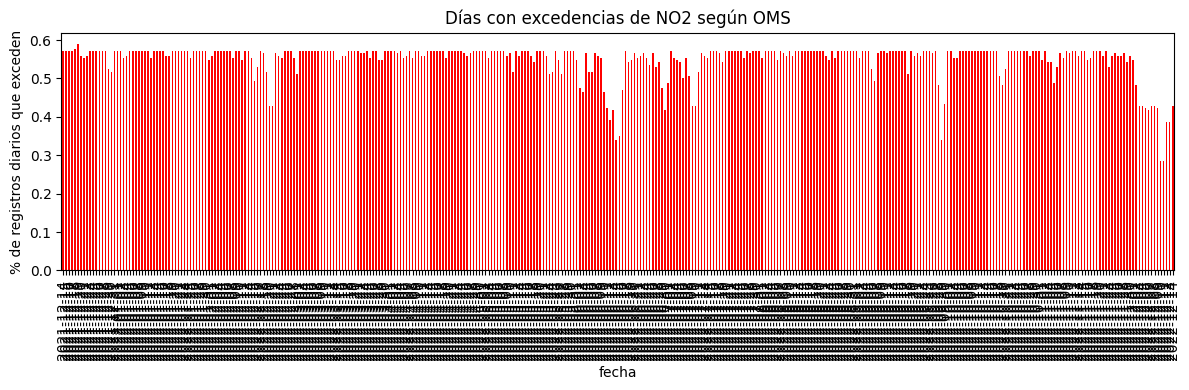

In [34]:
excesos_diarios = df.groupby(df['fecha'].dt.date)['excede_limite'].mean()

plt.figure(figsize=(12, 4))
excesos_diarios.plot(kind='bar', color='red')
plt.title(f'Días con excedencias de {contaminante.upper()} según OMS')
plt.ylabel('% de registros diarios que exceden')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

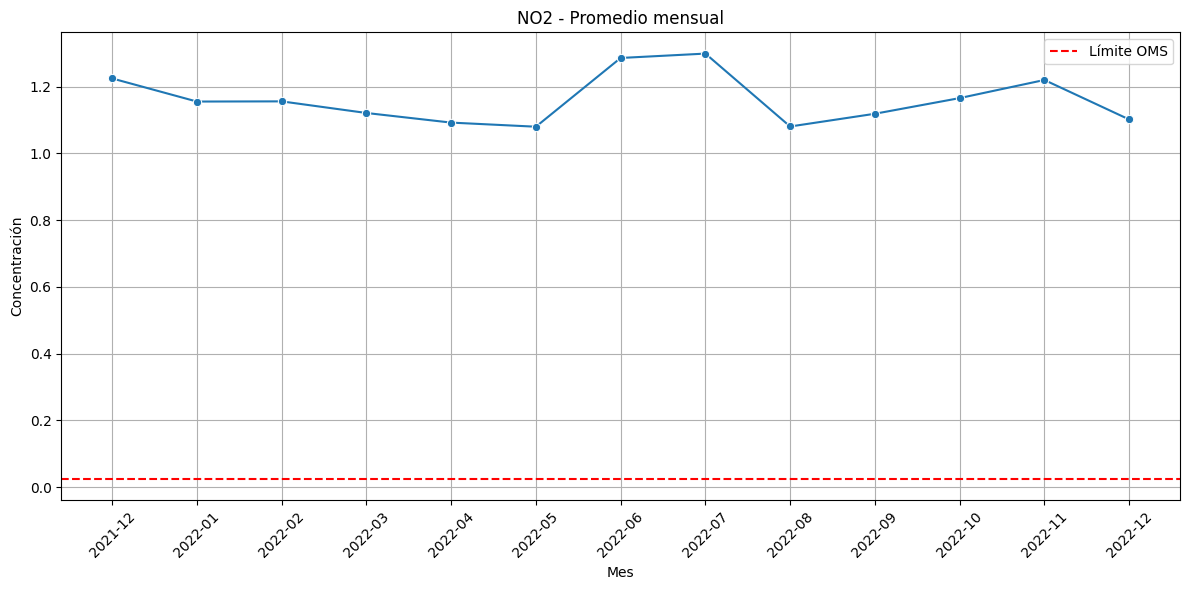

In [35]:
#comparar promedios mensuales con los limites
plt.figure(figsize=(12,6))
sns.lineplot(data=promedios_mensuales, x='mes', y='valor', marker='o')
if limite:
    plt.axhline(y=limite, color='red', linestyle='--', label='Límite OMS')
plt.title(f'{contaminante_unico.upper()} - Promedio mensual')
plt.xlabel('Mes')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

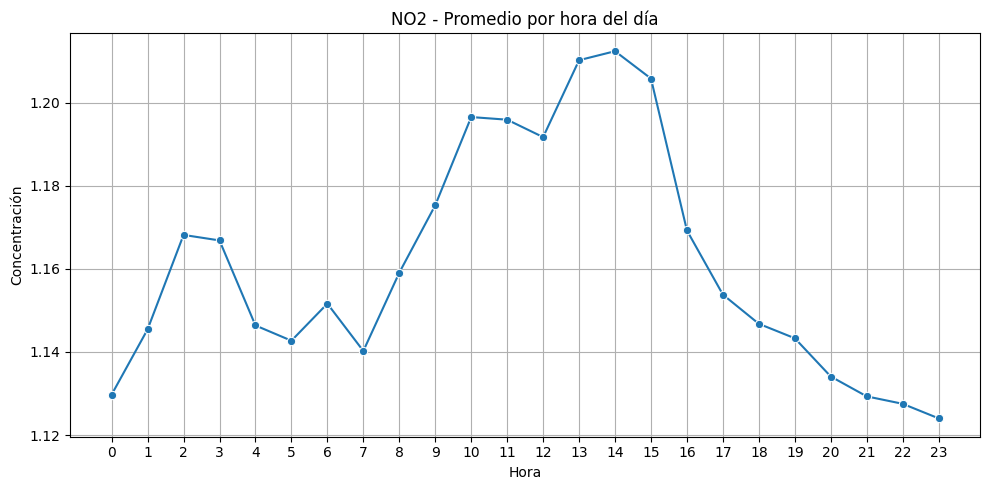

In [36]:
#variacion por hora del dia
df['hora'] = df['fecha'].dt.hour

horas = df.groupby('hora')['valor'].mean().reset_index()

plt.figure(figsize=(10,5))
sns.lineplot(data=horas, x='hora', y='valor', marker='o')
plt.title(f'{contaminante_unico.upper()} - Promedio por hora del día')
plt.xlabel('Hora')
plt.ylabel('Concentración')
plt.xticks(range(0,24))
plt.grid(True)
plt.tight_layout()
plt.show()

In [37]:
#Top 10 dias mas contaminados
top_dias = df.groupby(df['fecha'].dt.date)['valor'].mean().sort_values(ascending=False).head(10)
print("Días con mayor concentración promedio:")
print(top_dias)
promedio_eventos = df.groupby('evento')['valor'].mean().sort_values(ascending=False)


Días con mayor concentración promedio:
fecha
2022-06-15    1.818644
2022-06-20    1.767368
2022-06-16    1.763291
2022-03-02    1.644792
2022-06-19    1.583696
2022-06-18    1.553846
2022-07-13    1.536170
2022-03-01    1.525581
2022-06-17    1.525000
2022-07-21    1.522917
Name: valor, dtype: float64


C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_21316\496521658.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




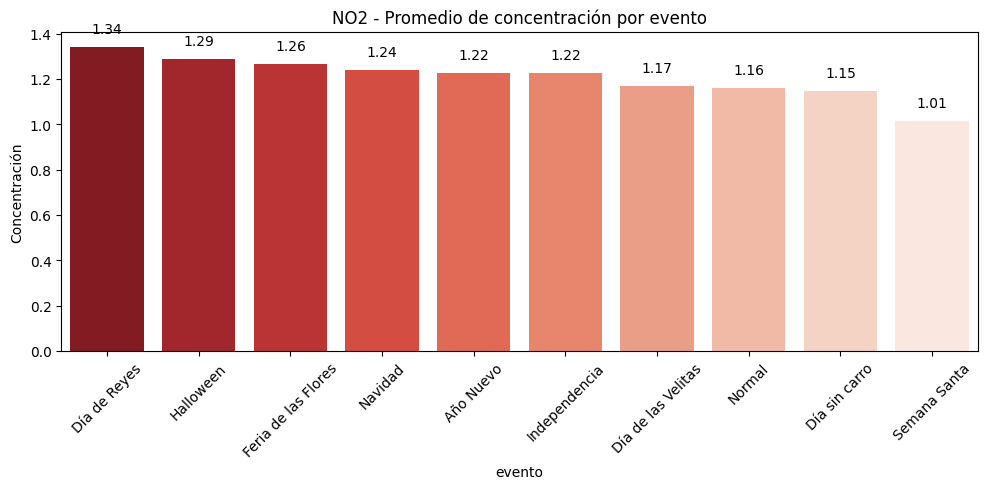

                     count      mean       std  min  max
evento                                                  
Día de Reyes            96  1.340625  0.554518  1.0  3.1
Halloween               96  1.286458  0.553956  1.0  3.1
Feria de las Flores    191  1.264921  0.437547  1.0  3.1
Navidad                 96  1.237500  0.403472  1.0  2.2
Año Nuevo               96  1.225000  0.391757  1.0  1.9
Independencia           96  1.225000  0.391757  1.0  1.9
Día de las Velitas      72  1.168056  0.533346  1.0  3.1
Normal               32694  1.159681  0.422704  1.0  3.1
Día sin carro           94  1.146809  0.387077  1.0  2.3
Semana Santa           192  1.014062  0.139784  1.0  2.6


In [38]:

# Convertir a DataFrame y ordenar por valor (descendente)
evento_df = promedio_eventos.reset_index()
evento_df.columns = ['evento', 'valor']
evento_df = evento_df.sort_values(by='valor', ascending=False).reset_index(drop=True)

# Crear una paleta personalizada basada en el número de eventos
paleta = sns.color_palette("Reds", n_colors=len(evento_df))

# Graficar
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=evento_df,
    x='evento', y='valor',
    palette=paleta[::-1]  # ahora sí, inverso en orden decreciente
)

# Agregar etiquetas
for i, val in enumerate(evento_df['valor']):
    ax.text(i, val + 0.05, f'{val:.2f}', ha='center', va='bottom')

plt.title(f'{contaminante_unico.upper()} - Promedio de concentración por evento')
plt.ylabel('Concentración')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
stats_eventos = df.groupby('evento')['valor'].agg(['count', 'mean', 'std', 'min', 'max']).sort_values(by='mean', ascending=False)
print(stats_eventos)

C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_21316\3242679077.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




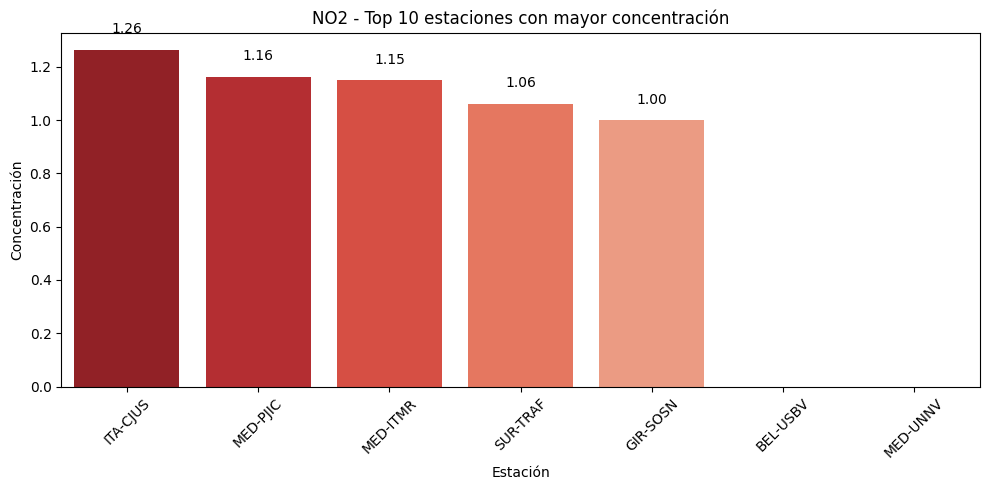

In [43]:
# Promedio por estación
top_estaciones = df.groupby('nombreCorto')['valor'].mean().sort_values(ascending=False).head(10).reset_index()

# Paleta de colores (más alta concentración = más oscuro)
paleta = sns.color_palette("Reds", n_colors=len(top_estaciones))

# Gráfico
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    data=top_estaciones,
    x='nombreCorto', y='valor',
    palette=paleta[::-1]
)

# Etiquetas
for i, val in enumerate(top_estaciones['valor']):
    ax.text(i, val + 0.05, f'{val:.2f}', ha='center', va='bottom')

plt.title(f'{contaminante_unico.upper()} - Top 10 estaciones con mayor concentración')
plt.ylabel('Concentración')
plt.xlabel('Estación')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

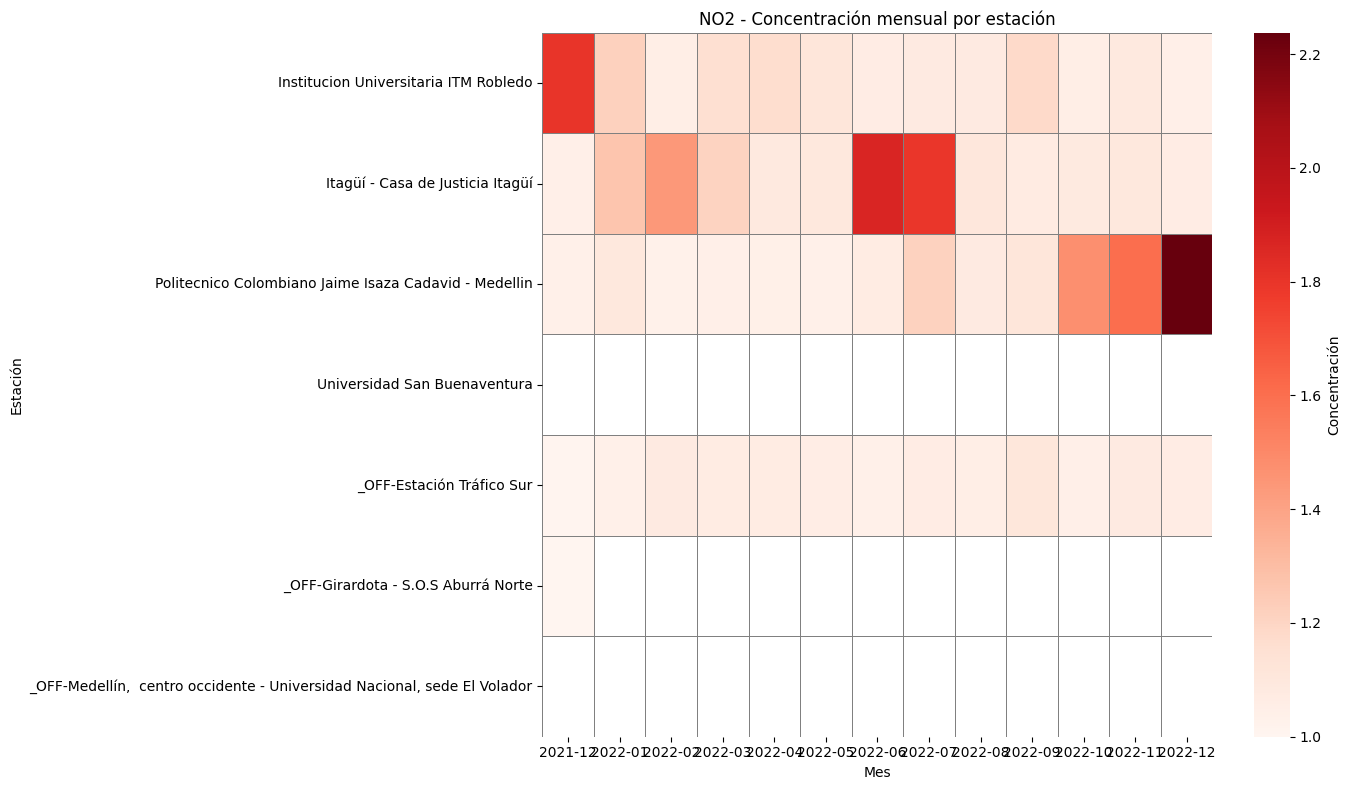

In [40]:
# Crear columna de mes
df['mes'] = df['fecha'].dt.to_period('M').astype(str)

# Agrupamos por estación y mes
pivot_df = df.groupby(['nombre', 'mes'])['valor'].mean().reset_index()

# Reorganizar en forma de matriz
pivot_table = pivot_df.pivot(index='nombre', columns='mes', values='valor')

# Crear heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(pivot_table, cmap="Reds", linewidths=0.5, linecolor='gray', annot=False, fmt=".1f", cbar_kws={'label': 'Concentración'})
plt.title(f'{contaminante_unico.upper()} - Concentración mensual por estación')
plt.xlabel('Mes')
plt.ylabel('Estación')
plt.tight_layout()
plt.show()

In [41]:


import plotly.express as px

# Asegurar que el mes esté como string
df['mes'] = df['fecha'].dt.to_period("M").astype(str)

# Calcular promedio mensual por estación
mapa_mensual = df.groupby(['nombre', 'latitud', 'longitud', 'mes'])['valor'].mean().reset_index()

media_mensual_limpio = mapa_mensual.dropna(subset=['valor'])

# Crear mapa animado
fig = px.scatter_mapbox(
    media_mensual_limpio,
    lat="latitud", lon="longitud",
    color="valor",
    size="valor",
    animation_frame="mes",
    hover_name="nombre",
    color_continuous_scale="Reds",
    size_max=15,
    zoom=10,
    mapbox_style="carto-positron",
    title=f'{contaminante_unico.upper()} - Concentración mensual por estación'
)

fig.update_layout(margin={"r":0,"t":40,"l":0,"b":0})
fig.show()

C:\Users\Jeronimo Zapata\AppData\Local\Temp\ipykernel_21316\1578024283.py:12: DeprecationWarning:

*scatter_mapbox* is deprecated! Use *scatter_map* instead. Learn more at: https://plotly.com/python/mapbox-to-maplibre/

